# Ex13: CG画像のスタイル表現

Lit-SphereとStyleBlitのスタイル表現をレンダリング画像の連番データに適用してみましょう．

## 必要なライブラリのインストール

In [1]:
# プログレスバー用ライブラリのインストール
! pip install fastprogress
from fastprogress import progress_bar

# 動画入出力に使うライブラリ
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Colab上での出力用ライブラリ
from IPython.display import HTML
import base64
import io

# 画像ベースのスタイル化の実装例

- Lit-Sphere
- StyleBlit

を実装しています．

どちらも，


```
I = litsphre(T, N)

I = styleblit(T, N)
```

の形でテクスチャTと法線画像Nからスタイル化した結果を得られます．



In [6]:
from sklearn.cluster import KMeans

# Lit-Sphere
def litsphre_lookup(T, Ni):
  # 画像の幅と高さの取得
  h, w = T.shape[:2]

  x = int(Ni[0] * (w-1))

  y = int((1.0-Ni[1]) * (h-1))
  
  return T[y, x, :]

# Lit-Sphere: 少し遅い
def litsphre_slow(T, N):
  h, w = N.shape[:2]
  A = N[:,:,3]

  I = np.array([litsphre_lookup(T, Ni) for Ni in N.reshape(-1, 4)])

  I = I.reshape(h, w, -1)[:,:,:3]
  I = np.dstack([I, A])
  return I

# Lit-Sphere: 高速バージョン
def litsphre(T, N):
  h, w = N.shape[:2]
  A = N[:,:,3]

  T_flat = T.reshape(-1, T.shape[2])
  N_flat = N.reshape(-1, 4)

  h, w = T.shape[:2]
  X = np.int32(N_flat[:,0]*(w-1))
  Y = np.int32((1.0-N_flat[:,1])*(h-1))

  I_flat = T_flat[w*Y+X, :]
  h, w = N.shape[:2]

  I = I_flat.reshape(h, w, -1)[:,:,:3]
  I = np.dstack([I, A])
  return I

# 画像ベースのスタイル化の実装
def styleblit(T, N):
  A = N[:,:,3]

  B = cv2.GaussianBlur(T, (0, 0), 15)
  D = T - B

  O_B = litsphre(B, N)

  h, w = N.shape[:2]
  N_flat = N.reshape(-1, 4)

  scale_P = 3.0

  Px, Py = np.meshgrid(np.linspace(0.0, 1.0, w), np.linspace(0.0, 1.0, h))
  P = scale_P * np.dstack((Px, Py)).reshape(-1, 2)
  F = np.hstack((N_flat, P))

  kmeans = KMeans(n_clusters=70, random_state=0).fit(F[::500, :])
  F_centers = kmeans.cluster_centers_
  labels = kmeans.predict(F)

  N_x = kmeans.cluster_centers_[labels, 0]
  N_y = kmeans.cluster_centers_[labels, 1]

  X_d = (P[:,0] - kmeans.cluster_centers_[labels, -2])*(w-1) 
  Y_d = (P[:,1] - kmeans.cluster_centers_[labels, -1])*(h-1) 

  h, w = T.shape[:2]
  X = np.clip(np.int32(N_x*(w-1)+X_d), 0, w-1)
  Y = np.clip(np.int32((1.0-N_y)*(h-1)+Y_d), 0, h-1)

  D_flat = D.reshape(h*w, -1)
  O_D_flat = D_flat[w*Y+X, :]

  h, w = N.shape[:2]
  O_D = O_D_flat.reshape(h, w, -1)
  O = O_B + O_D
  O = np.clip(O, 0, 1)
  O = np.dstack([O[:,:,:3], A])
  
  return O

## 補助関数

In [7]:
import numpy as np
import cv2
import matplotlib.pyplot as plt


# 画像読み込み
def imread(img_file):
  I = cv2.imread(img_file, -1)
  I = cv2.cvtColor(I, cv2.COLOR_BGRA2RGBA)
  return np.float32(I) / 255.0

# フレーム画像の読み込み
def frameread(N_dir, frame):
  N_file = N_dir / ("normal%04d.png" %frame)
  N = imread(str(N_file))
  N[:,:,:3] = cv2.bilateralFilter(N[:,:,:3], 7, sigmaColor=0.2, sigmaSpace=7)
  return N

# フレーム画像の書き込み
def framewrite(writer, I):
  bg_color = [0.2, 0.25, 0.25]
  I2 = np.array(I)
  A = I[:,:,3]
  for ci in range(3):
    I2[:,:,ci] = A * I[:,:,ci] + (1.0 - A) * bg_color[ci] 
  I2 = np.uint8(I2*255)
  I2 = cv2.cvtColor(I2, cv2.COLOR_RGBA2BGRA)
  writer.write(I2[:,:,:3])

# テクスチャ読み込み
def texread(img_file):
  I = cv2.imread(img_file, -1)
  I = cv2.cvtColor(I, cv2.COLOR_BGRA2RGBA)
  I = cv2.resize(I, dsize=(1024, 1024))
  return np.float32(I) / 255.0


# 入力画像のプロット
def plot_inputs(T, N):
  fig = plt.figure(figsize=(12,6))
  plt.subplot(1, 2, 1)
  plt.imshow(T)
  plt.axis("off")
  plt.title("2D Texture")

  ax = plt.subplot(1, 2, 2)
  ax.patch.set_facecolor([0.2, 0.25, 0.25]) 
  plt.imshow(N)
  plt.xticks([])
  plt.yticks([])
  plt.title("Normal")


# レンダリング画像を各フレームをスタイル化して動画出力する関数
def style_video(out_file, style_func, T, N_dir, frame_end=10, codec="vp80"): 
  fps = 8.0

  N = frameread(N_dir, 1)

  h, w = N.shape[:2]

  fourcc = cv2.VideoWriter_fourcc(*codec)
  writer = cv2.VideoWriter(out_file, fourcc, fps, (w, h))

  for frame in progress_bar(range(1, frame_end)):
    N = frameread(N_dir, frame)
    I = style_func(T, N)
    framewrite(writer, I)

  # 動画オブジェクトの解放
  writer.release()


# 動画HTML表示する関数
def display_video(video_file):
  cap = cv2.VideoCapture(video_file)
  w = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
  h = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
  cap.release()
  video = io.open(video_file, 'r+b').read()
  encoded = base64.b64encode(video)
  html_code = '''<video width="40%" height="40%" controls><source src="data:video/mp4;base64,{0}" type="video/mp4" /></video>'''
 
  return(HTML(data=html_code.format(encoded.decode('ascii'))))

## 入力画像の設定

レンダリング画像を使ってスタイル化を実験しましょう．
- tex_fileを色々切り替えて実験してください．
- N_zipを色々切り替えて実験してください．

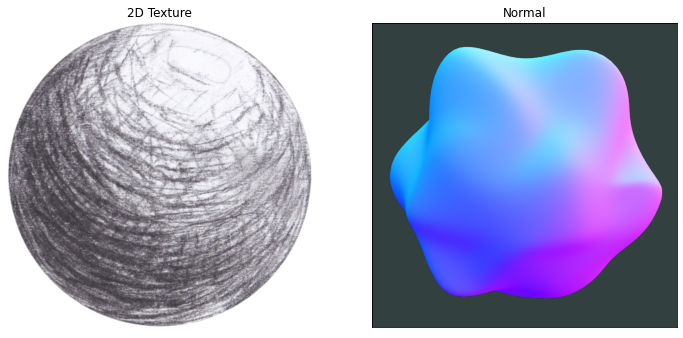

In [38]:
import pathlib
#@title Shadingパラメータ

#@markdown 2Dテクスチャ画像
tex_file = "/content/09.png"  #@param {type:"string"}
T = texread(tex_file)

#@markdown 法線画像のZipファイル
N_zip = "/content/blobby.zip"  #@param {type:"string"}

N_dir = pathlib.Path(pathlib.Path(N_zip).stem)

if not N_dir.exists():
  !unzip '{N_zip}'

N = frameread(N_dir, 1)

plot_inputs(T, N)

## Lit-Sphereの結果確認

Text(0.5, 1.0, 'Lit-Sphere')

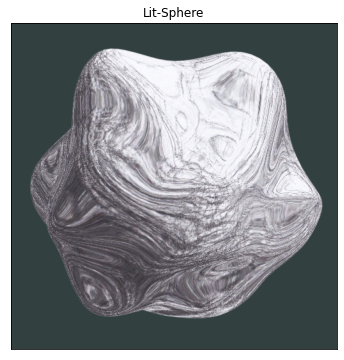

In [42]:
I = litsphre(T, N)

fig = plt.figure(figsize=(12,6))
ax = plt.subplot(1, 1, 1)
ax.patch.set_facecolor([0.2, 0.25, 0.25]) 
plt.imshow(I)
plt.xticks([])
plt.yticks([])
plt.title("Lit-Sphere")

## StyleBlitの結果確認

Text(0.5, 1.0, 'StyleBlit')

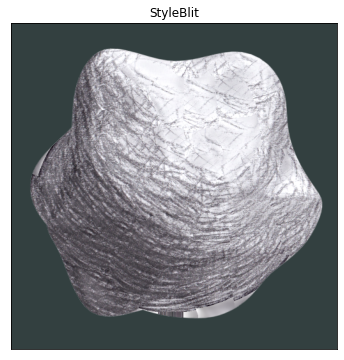

In [43]:
I = styleblit(T, N)

fig = plt.figure(figsize=(12,6))
ax = plt.subplot(1, 1, 1)
ax.patch.set_facecolor([0.2, 0.25, 0.25]) 
plt.imshow(I)
plt.xticks([])
plt.yticks([])
plt.title("StyleBlit")

## Lit-Sphereの動画出力結果

frame_endで動画フレーム数を指定できます．
速いので，frame_end=30で基本問題ないです．

In [44]:
out_file = "litsphre.webm"

style_video(out_file, litsphre, T, N_dir, frame_end=30)

# 出力動画の表示  
display_video(out_file)

Output hidden; open in https://colab.research.google.com to view.

## StyleBlitの動画出力結果

処理が重いので，frame_end=10くらいで実験して，
全フレーム処理したい場合はframe_end=30に指定してください．

In [45]:
out_file = "styleblit.webm"

style_video(out_file, styleblit, T, N_dir, frame_end=10)

# 出力動画の表示  
display_video(out_file)